In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as datetime
from datetime import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, text, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
engine.execute(text("SELECT name FROM sqlite_schema WHERE type='table' ORDER BY name")).fetchall()

[('measurement',), ('station',)]

In [6]:
engine.execute(text("select * from measurement limit 5")).fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [7]:
engine.execute(text("select * from station limit 5")).fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [8]:
inspector = inspect(engine)

In [9]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [12]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [13]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [14]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [15]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

'2017-08-23'

In [16]:
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
# Calculate the date one year from the last date in data set.
one_year_before = (dt.strptime(latest_date,"%Y-%m-%d") - datetime.timedelta(days=7)).date()

print(one_year_before)

2017-08-16


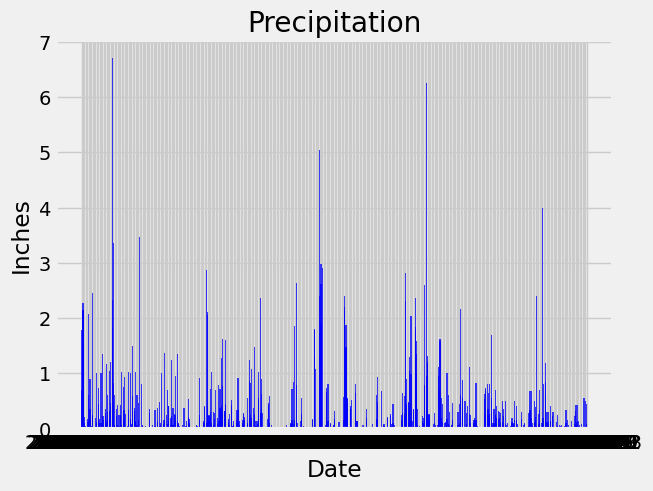

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

# Calculate the date one year from the last date in data set.
query_date = (dt.strptime(latest_date,"%Y-%m-%d") - datetime.timedelta(days=365)).date()

# Perform a query to retrieve the data and precipitation scores
score_data = session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).\
    filter(Measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
score_df = pd.DataFrame(score_data, columns = ['ID', 'Station', 'Date', 'PRCP', 'TOBS'])


# Sort the dataframe by date
score_df = score_df.sort_values(by=['Date']).reset_index(drop=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.title("Precipitation")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.bar(score_df['Date'], score_df['PRCP'], facecolor="blue", alpha=0.75, align="center")
plt.show()

In [18]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary = score_df[['PRCP']].describe()
precipitation_summary

,PRCP
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [19]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(Measurement.station).group_by(Measurement.station).count()
station_count

9

In [20]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).\
    all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = active_stations[0][0]

lowest = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active).all()
highest = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active).all()
average = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active).all()

print(f"lowest temperature: {lowest[0][0]}")
print(f"highest temperature: {highest[0][0]}")
print(f"average temperature: {average[0][0]}")

lowest temperature: 54.0
highest temperature: 85.0
average temperature: 71.66378066378067


array([[<Axes: title={'center': 'Temperature'}>]], dtype=object)

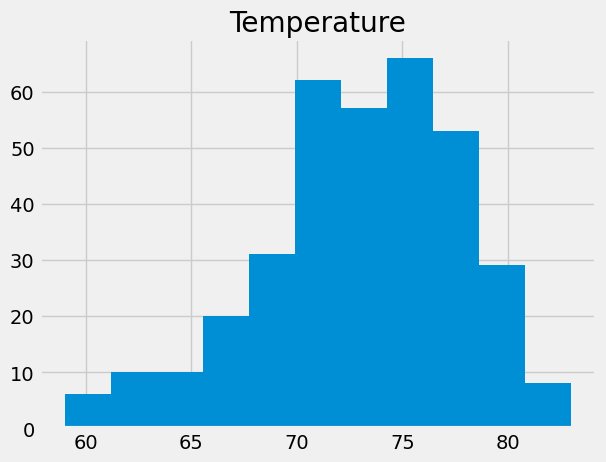

In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active).\
    filter(Measurement.date >= query_date).\
    all()
temp_df = pd.DataFrame(temp_data, columns = ['Temperature'])
temp_df.hist(bins=11)

# Close Session

In [23]:
# Close Session
session.close()